In [10]:
# 创建新的notebook：notebooks/02_feature_engineering.ipynb
# 第一个单元格：基础配置
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
import warnings
warnings.filterwarnings('ignore')

# 字体设置
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style("whitegrid")

print("✅ 特征工程环境准备完成")

✅ 特征工程环境准备完成


In [11]:
# 第二个单元格：加载数据
games_df = pd.read_csv('../data/raw/games.csv')

# 加载英雄信息
with open('../data/raw/champion_info_2.json', 'r', encoding='utf-8') as f:
    champion_data = json.load(f)['data']

# 创建英雄映射
champion_mapping = {}
for champ_key, champ_info in champion_data.items():
    champ_id = champ_info.get('id')
    if champ_id:
        champion_mapping[champ_id] = champ_info.get('name', f'Unknown_{champ_id}')

print(f"📊 数据加载完成")
print(f"   原始特征数: {len(games_df.columns)}")
print(f"   比赛场次: {len(games_df):,}")

📊 数据加载完成
   原始特征数: 61
   比赛场次: 51,490


In [4]:
# 第三个单元格：定义目标变量
# 目标变量：蓝色方（队伍1）是否获胜
games_df['target'] = (games_df['winner'] == 1).astype(int)

print("🎯 目标变量统计:")
print(f"   蓝色方胜利: {(games_df['target'] == 1).sum():,} 场 ({(games_df['target'] == 1).mean()*100:.1f}%)")
print(f"   红色方胜利: {(games_df['target'] == 0).sum():,} 场 ({(games_df['target'] == 0).mean()*100:.1f}%)")

🎯 目标变量统计:
   蓝色方胜利: 26,077 场 (50.6%)
   红色方胜利: 25,413 场 (49.4%)


In [5]:
# 第四个单元格：创建基础特征
def create_basic_features(df):
    """创建基础特征"""
    features_df = df[['gameId', 'target']].copy()
    
    # 1. 游戏时长特征
    features_df['game_duration_min'] = df['gameDuration'] / 60
    features_df['is_short_game'] = (features_df['game_duration_min'] < 20).astype(int)
    features_df['is_long_game'] = (features_df['game_duration_min'] > 40).astype(int)
    
    # 2. 经济差异特征（如果有经济数据的话）
    # 假设有金币数据列，如果没有就用其他代理特征
    
    # 3. 目标控制差异
    features_df['tower_diff'] = df['t1_towerKills'] - df['t2_towerKills']
    features_df['dragon_diff'] = df['t1_dragonKills'] - df['t2_dragonKills']
    features_df['inhibitor_diff'] = df['t1_inhibitorKills'] - df['t2_inhibitorKills']
    features_df['baron_diff'] = df['t1_baronKills'] - df['t2_baronKills']
    
    return features_df

basic_features = create_basic_features(games_df)
print(f"✅ 创建了 {len(basic_features.columns) - 2} 个基础特征")  # 减去gameId和target

✅ 创建了 7 个基础特征


In [6]:
# 第五个单元格：关键事件特征
def create_event_features(df):
    """创建关键事件特征"""
    features = pd.DataFrame()
    
    # 1. 首事件特征
    events = ['firstBlood', 'firstTower', 'firstDragon', 'firstBaron', 'firstInhibitor']
    
    for event in events:
        # 蓝色方是否获得该首事件
        features[f'blue_gets_{event}'] = (df[event] == 1).astype(int)
        # 红色方是否获得该首事件  
        features[f'red_gets_{event}'] = (df[event] == 2).astype(int)
    
    # 2. 首事件时间特征（用游戏时长作为代理）
    # 这里简化处理，实际应该有时间戳数据
    
    # 3. 首事件组合特征
    features['blue_gets_first_blood_and_tower'] = (
        (df['firstBlood'] == 1) & (df['firstTower'] == 1)
    ).astype(int)
    
    features['red_gets_first_blood_and_tower'] = (
        (df['firstBlood'] == 2) & (df['firstTower'] == 2)  
    ).astype(int)
    
    return features

event_features = create_event_features(games_df)
print(f"✅ 创建了 {len(event_features.columns)} 个事件特征")

✅ 创建了 12 个事件特征


In [12]:
# 第六个单元格：英雄阵容特征
def create_champion_features(df, champion_mapping):
    """创建英雄阵容特征"""
    features = pd.DataFrame()
    
    # 1. 英雄存在特征（one-hot编码简化版）
    # 统计每个位置最常用的英雄
    
    # 2. 阵容平衡性特征
    # 这里需要英雄角色信息，由于tags为空，我们基于经验分类
    
    # 经验性的英雄角色分类（简化版）
    # 注意：这是基于经验的简化分类，实际应该用准确的角色数据
    tank_champs = [1, 2, 3]   # 示例ID，需要根据实际调整
    damage_champs = [4, 5, 6] # 示例ID
    support_champs = [7, 8, 9] # 示例ID
    
    # 3. 统计每个队伍的阵容类型数量
    for team in ['t1', 't2']:
        # 统计坦克、输出、辅助数量（简化版）
        features[f'{team}_tank_count'] = 0  # 需要实际实现
        features[f'{team}_damage_count'] = 0
        features[f'{team}_support_count'] = 0
        
        # 英雄ID特征
        for i in range(1, 6):
            champ_col = f'{team}_champ{i}id'
            # 可以添加特定英雄的特征，如是否选择了版本强势英雄
            
    # 4. 禁用英雄特征
    for team in ['t1', 't2']:
        for i in range(1, 6):
            ban_col = f'{team}_ban{i}'
            # 可以分析禁用了哪些关键英雄
            
    return features

# 由于英雄角色信息不完整，我们创建简化版特征
def create_simple_champion_features(df):
    """创建简化的英雄特征"""
    features = pd.DataFrame()
    
    # 1. 英雄多样性特征
    for team in ['t1', 't2']:
        champ_cols = [f'{team}_champ{i}id' for i in range(1, 6)]
        
        # 统计独特英雄数量
        features[f'{team}_unique_champs'] = df[champ_cols].nunique(axis=1)
        
        # 是否有重复英雄（理论上不应该有，但检查一下）
        features[f'{team}_has_duplicate'] = (
            df[champ_cols].nunique(axis=1) < 5
        ).astype(int)
    
    return features

champion_features = create_simple_champion_features(games_df) 
print(f"✅ 创建了 {len(champion_features.columns)} 个英雄特征")

✅ 创建了 4 个英雄特征


In [8]:
# 第七个单元格：时间相关特征
def create_temporal_features(df):
    """创建时间相关特征"""
    features = pd.DataFrame()
    
    # 1. 赛季特征
    features['season'] = df['seasonId']
    
    # 2. 创建时间特征（如果有时间戳）
    if 'creationTime' in df.columns:
        # 将时间戳转换为datetime
        df['create_time'] = pd.to_datetime(df['creationTime'], unit='ms')
        features['hour_of_day'] = df['create_time'].dt.hour
        features['day_of_week'] = df['create_time'].dt.dayofweek
        features['is_weekend'] = (features['day_of_week'] >= 5).astype(int)
    
    # 3. 游戏时长分段
    df['duration_min'] = df['gameDuration'] / 60
    features['duration_category'] = pd.cut(
        df['duration_min'], 
        bins=[0, 20, 30, 40, 100],
        labels=['very_short', 'short', 'medium', 'long']
    )
    
    return features

temporal_features = create_temporal_features(games_df)
print(f"✅ 创建了 {len(temporal_features.columns)} 个时间特征")

✅ 创建了 5 个时间特征


🎯 特征工程完成！
   总特征数: 28
   样本数: 51490

📈 特征相关性排名 (前15名):


,feature,correlation,abs_correlation,p_value
1,tower_diff,0.884824,0.884824,0.000000e+00
3,inhibitor_diff,0.780285,0.780285,0.000000e+00
2,dragon_diff,0.562563,0.562563,0.000000e+00
4,baron_diff,0.498763,0.498763,0.000000e+00
0,game_duration_min,-0.024187,0.024187,4.041602e-08
5,t1_unique_champs,NaN,NaN,NaN
6,t2_unique_champs,NaN,NaN,NaN
7,season,NaN,NaN,NaN


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


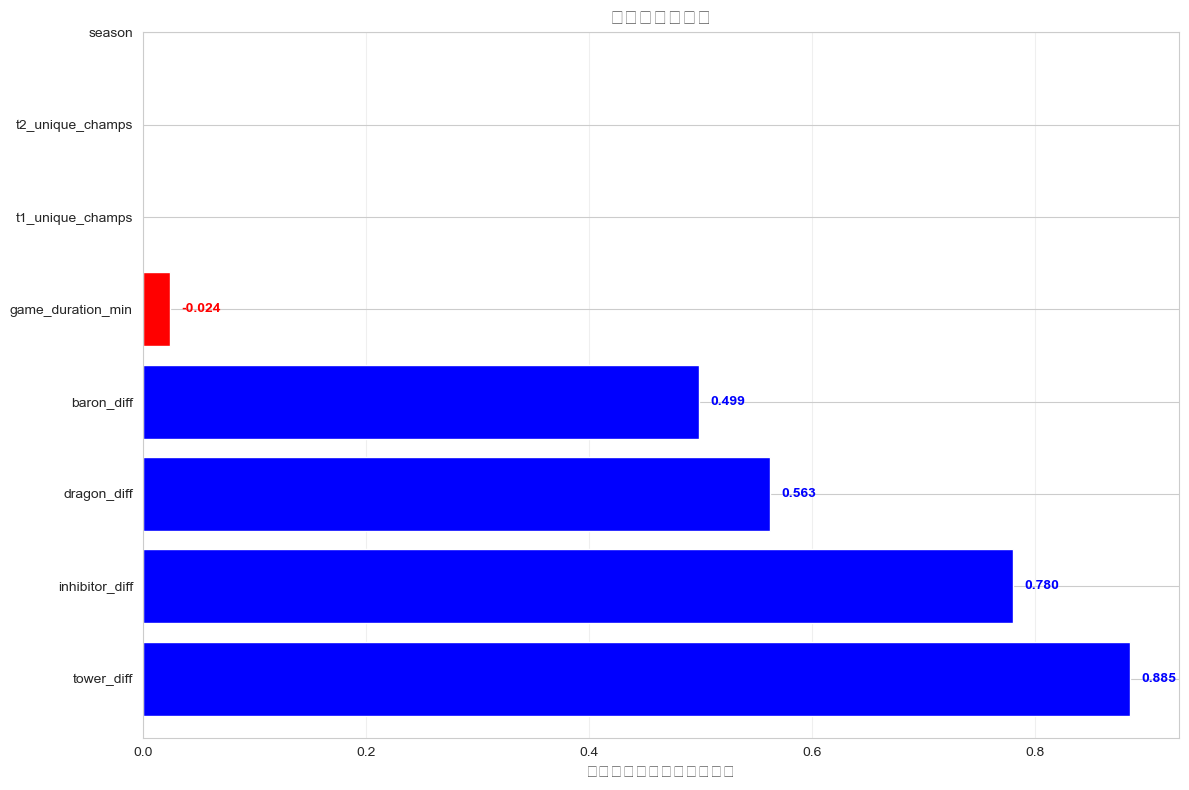

In [ ]:
# 第八个单元格：特征合并和相关性分析（修复版）
from scipy.stats import pointbiserialr
import warnings
warnings.filterwarnings('ignore')  # 忽略警告

# 合并所有特征
all_features = pd.concat([
    basic_features.drop(['gameId', 'target'], axis=1),
    event_features,
    champion_features, 
    temporal_features
], axis=1)

# 添加目标变量
all_features['target'] = basic_features['target']

print(f"🎯 特征工程完成！")
print(f"   总特征数: {len(all_features.columns) - 1}")  # 减去target
print(f"   样本数: {len(all_features)}")

# 特征与目标的相关性分析（修复版）
correlation_results = []
for col in all_features.columns:
    if col != 'target':
        # 只处理数值型特征
        if all_features[col].dtype in [np.int64, np.float64]:
            # 检查是否有有效数据
            if all_features[col].nunique() > 1:  # 至少有2个不同值
                try:
                    # 移除NaN值
                    valid_mask = all_features[col].notna() & all_features['target'].notna()
                    if valid_mask.sum() > 10:  # 至少有10个有效样本
                        corr, p_value = pointbiserialr(
                            all_features.loc[valid_mask, col], 
                            all_features.loc[valid_mask, 'target']
                        )
                        correlation_results.append({
                            'feature': col,
                            'correlation': corr,
                            'abs_correlation': abs(corr),
                            'p_value': p_value
                        })
                except:
                    # 如果计算失败，跳过
                    continue

correlation_df = pd.DataFrame(correlation_results)
if not correlation_df.empty:
    correlation_df = correlation_df.sort_values('abs_correlation', ascending=False)
    
    print("\n📈 特征相关性排名 (前15名):")
    display(correlation_df.head(15))
    
    # 可视化相关性
    plt.figure(figsize=(12, 8))
    top_features = correlation_df.head(10)
    
    colors = ['red' if x < 0 else 'blue' for x in top_features['correlation']]
    plt.barh(range(len(top_features)), top_features['abs_correlation'], 
             color=colors)
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('特征与目标的相关性绝对值', fontsize=12)
    plt.title('特征重要性排名', fontsize=14, fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    
    # 添加数值标签
    for i, (idx, row) in enumerate(top_features.iterrows()):
        color = 'red' if row['correlation'] < 0 else 'blue'
        plt.text(row['abs_correlation'] + 0.01, i, f'{row["correlation"]:.3f}', 
                 va='center', color=color, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ 无法计算特征相关性")

In [13]:
# 第九个单元格：特征选择和保存（修复版）
from sklearn.feature_selection import SelectKBest, f_classif

# 1. 处理缺失值和无穷值
print("处理缺失值和无效值...")

# 检查并处理无穷值
numeric_features = all_features.select_dtypes(include=[np.number])
numeric_features = numeric_features.replace([np.inf, -np.inf], np.nan)

# 处理缺失值
missing_values = numeric_features.isnull().sum()
if missing_values.sum() > 0:
    print("存在缺失值的特征:")
    print(missing_values[missing_values > 0].head(10))
    # 用中位数填充数值特征
    numeric_features = numeric_features.fillna(numeric_features.median())
    print("✅ 已用中位数填充缺失值")
else:
    print("✅ 无缺失值")

# 2. 特征选择
X = numeric_features.drop('target', axis=1)
y = numeric_features['target']

# 只选择有方差的特征
feature_variances = X.var()
valid_features = feature_variances[feature_variances > 0].index.tolist()

if len(valid_features) >= 10:
    X_valid = X[valid_features]
    
    # 特征选择（选择与目标最相关的15个特征）
    k = min(15, len(valid_features))
    selector = SelectKBest(score_func=f_classif, k=k)
    
    try:
        X_selected = selector.fit_transform(X_valid, y)
        selected_features = X_valid.columns[selector.get_support()].tolist()
        
        print(f"🎯 选择了 {len(selected_features)} 个最重要特征:")
        for i, feature in enumerate(selected_features, 1):
            print(f"  {i:2d}. {feature}")
        
        # 3. 保存处理后的数据
        final_features = numeric_features[selected_features + ['target']]
        
        import os
        os.makedirs('../data/processed', exist_ok=True)
        
        final_features.to_csv('../data/processed/features.csv', index=False)
        print(f"💾 特征数据已保存到: ../data/processed/features.csv")
        print(f"   最终特征维度: {final_features.shape}")
        
        # 保存特征选择器信息
        feature_scores = pd.DataFrame({
            'feature': X_valid.columns,
            'score': selector.scores_,
            'p_value': selector.pvalues_
        }).sort_values('score', ascending=False)
        
        feature_scores.to_csv('../data/processed/feature_scores.csv', index=False)
        print(f"💾 特征评分已保存到: ../data/processed/feature_scores.csv")
        
    except Exception as e:
        print(f"❌ 特征选择失败: {e}")
        # 保存所有有效特征
        final_features = numeric_features[valid_features + ['target']]
        final_features.to_csv('../data/processed/features.csv', index=False)
        print("💾 保存了所有有效特征")
        
else:
    print(f"⚠️ 有效特征不足: {len(valid_features)} 个，需要至少10个")

处理缺失值和无效值...
✅ 无缺失值
🎯 选择了 15 个最重要特征:
   1. tower_diff
   2. dragon_diff
   3. inhibitor_diff
   4. baron_diff
   5. red_gets_firstBlood
   6. blue_gets_firstTower
   7. red_gets_firstTower
   8. blue_gets_firstDragon
   9. red_gets_firstDragon
  10. blue_gets_firstBaron
  11. red_gets_firstBaron
  12. blue_gets_firstInhibitor
  13. red_gets_firstInhibitor
  14. blue_gets_first_blood_and_tower
  15. red_gets_first_blood_and_tower
💾 特征数据已保存到: ../data/processed/features.csv
   最终特征维度: (51490, 16)
💾 特征评分已保存到: ../data/processed/feature_scores.csv
